### Survival Analysis

In [1]:
library(tidyverse)
library(survival)
library(survminer)
library(janitor)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




### Loading Predicted gene expression and matched survival data

In [2]:
survival_info = read.csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_survival_info.csv")
table(survival_info$vital_status)
final_gene_mean_counts = read.csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_final_gene_mean_counts.csv")
head(final_gene_mean_counts)


Alive  Dead 
  276    30 

,X,ISG15,TNFRSF18,TNFRSF4,CALML6,HES5,TNFRSF14,TNFRSF25,TNFRSF9,ERRFI1,⋯,CD40LG,FGF13,SPANXB1,MAGEA4,MAGEA12,IRAK1,FLNA,DNASE1L1,G6PD,IKBKG
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TCGA-3C-AALK-01A,1.5430058,0.27887609,0.21269230,0.003786176,0.0046080790,0.5857883,0.15705630,0.012995223,0.2285918,⋯,0.016354198,0.01719971,4.839454e-05,0.002419014,0.0002293875,0.5628867,1.2358707,0.20166089,0.2945019,0.2020836
2,TCGA-A2-A0YT-01A,0.7912554,0.08288524,0.06785237,0.002122796,0.0015072048,0.2588072,0.09584118,0.011958410,0.2911050,⋯,0.006835344,0.03614483,4.810764e-05,0.000935946,0.0001515330,0.4708992,1.1173518,0.14086240,0.1466678,0.1441185
3,TCGA-A7-A0DC-01Z,0.7927799,0.09203718,0.08699198,0.001483693,0.0009758033,0.2661798,0.07470937,0.007744327,0.1519087,⋯,0.006919952,0.02083637,1.105339e-04,0.016377954,0.0022309875,0.4125181,0.8376562,0.07590099,0.1554975,0.1298065
4,TCGA-A2-A25A-01Z,1.1891968,0.24786741,0.10969754,0.001839675,0.0025297209,0.4503545,0.11648071,0.006441460,0.1659888,⋯,0.011106775,0.02280141,8.418980e-05,0.003776430,0.0004853048,0.5855997,1.0629072,0.13166461,0.2590116,0.1853268
5,TCGA-A2-A0T7-01Z,1.6464207,0.25951228,0.13267578,0.002291477,0.0035728991,0.5364273,0.14035429,0.010091309,0.1834937,⋯,0.012612580,0.02758200,3.387335e-05,0.005271472,0.0004154778,0.8040864,1.1287830,0.17748882,0.3378612,0.2601034
6,TCGA-A7-A0CE-11A,0.8249560,0.07302775,0.06895721,0.001959529,0.0014342508,0.2135593,0.09411187,0.009462215,0.1968223,⋯,0.007449792,0.02935756,3.577373e-04,0.002755121,0.0006465447,0.3721164,0.9580938,0.09053418,0.1187063,0.1160976


In [3]:
survival_info = read.csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_survival_info.csv")

final_gene_mean_counts = read.csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_final_gene_mean_counts.csv")
final_gene_mean_counts = t(final_gene_mean_counts)
final_gene_mean_counts <- janitor::row_to_names(final_gene_mean_counts,1)
genes <- rownames(final_gene_mean_counts)
final_gene_mean_counts <- as.data.frame(final_gene_mean_counts)
final_gene_mean_counts <- apply(final_gene_mean_counts, 2, function(x) as.numeric(as.character(x)))
rownames(final_gene_mean_counts) <- genes
final_gene_mean_counts <- t(final_gene_mean_counts)
final_gene_mean_counts <- as.data.frame(final_gene_mean_counts)
rownames(final_gene_mean_counts) <- gsub("\\.", "-", rownames(final_gene_mean_counts))
final_gene_mean_counts$pateint <- sub("\\-1$", "", rownames(final_gene_mean_counts))
final_gene_mean_counts$pateint_surv <- substring(final_gene_mean_counts$pateint, 1, 
                                              nchar(final_gene_mean_counts$pateint) - 4)
                                
survival_info <- unique(survival_info[c("case_id","case_submitter_id","time","vital_status","ajcc_pathologic_stage")])

##############################################################################################################################
                                
survival_info_2 <- data.frame(col1 = character(0))
df_counts <- table(final_gene_mean_counts$pateint_surv)
for (value in unique(final_gene_mean_counts$pateint_surv)) {
  rows_df2 <- survival_info[survival_info$case_submitter_id == value, , drop = FALSE]
  replicated_rows <- rows_df2[rep(seq_len(nrow(rows_df2)), df_counts[value]), , drop = FALSE]
  survival_info_2 <- rbind(survival_info_2, replicated_rows)}
rownames(survival_info_2) <- NULL
survival_info_2 = survival_info_2[order(survival_info_2$case_submitter_id), ]

final_gene_mean_counts = final_gene_mean_counts[order(final_gene_mean_counts$pateint_surv), ]
final_gene_mean_counts = final_gene_mean_counts[final_gene_mean_counts$pateint_surv %in% survival_info_2$case_submitter_id,]

data = merge(survival_info[c("case_submitter_id","time","vital_status")], 
                   final_gene_mean_counts, by.x = "case_submitter_id", by.y = "pateint_surv")

unique_data <- data[!duplicated(data), ]
colnames(unique_data)[3] <- "status" 
unique_data$status <- ifelse(unique_data$status == "Dead", 1, 0)
colnames(unique_data) <- gsub("[[:space:]-]+", "_", colnames(unique_data))
                            

Warning message:
“Row 1 does not provide unique names. Consider running clean_names() after row_to_names().”


### Predicted gene expression

In [ ]:
covariates <- colnames(unique_data)[4:1525]
univ_formulas <- sapply(covariates,
                        function(x) as.formula(paste('Surv(time, status)~', x)))
                        
univ_models <- lapply( univ_formulas, function(x){coxph(x, data = unique_data)})
# Extract data 
univ_results <- lapply(univ_models,
                       function(x){ 
                          x <- summary(x)
                          p.value<-signif(x$wald["pvalue"], digits=2)
                          wald.test<-signif(x$wald["test"], digits=2)
                          beta<-signif(x$coef[1], digits=2);#coeficient beta
                          HR <-signif(x$coef[2], digits=2);#exp(beta)
                          HR.confint.lower <- signif(x$conf.int[,"lower .95"], 2)
                          HR.confint.upper <- signif(x$conf.int[,"upper .95"],2)
                          HR <- paste0(HR, " (", 
                                       HR.confint.lower, "-", HR.confint.upper, ")")
                          res<-c(beta, HR, wald.test, p.value)
                          names(res)<-c("beta", "HR (95% CI for HR)", "wald.test", 
                                        "p.value")
                          return(res)
                          #return(exp(cbind(coef(x),confint(x))))
                         })
res <- t(as.data.frame(univ_results, check.names = FALSE))
res = as.data.frame(res)
res_sig = rownames(res[res$p.value<0.05,])
                        
#####===========#####===========#####===========#####===========#####===========#####===========
                        
top_predict_genes <- read.csv("/scratch/project/stseq/Onkar/STimage_v1/stimage_LOOCV_9visium_top300gene.csv")
top_predict_genes <- top_predict_genes[top_predict_genes$Gene %in% res_sig,]
top_predict_genes <- top_predict_genes %>%
                 group_by(Gene) %>%
                 summarise(mean_value = mean(Pearson.correlation, na.rm = TRUE)) %>%
                 arrange(desc(mean_value))

#### Running for multiple top genes

[1] "SRSF2"  "GTF2I"  "CTNNA1" "STMN1"  "EPCAM" 
 [1] "SRSF2"  "GTF2I"  "CTNNA1" "STMN1"  "EPCAM"  "RAD21"  "LAMP1"  "PCNA"  
 [9] "PDIA6"  "GPI"   


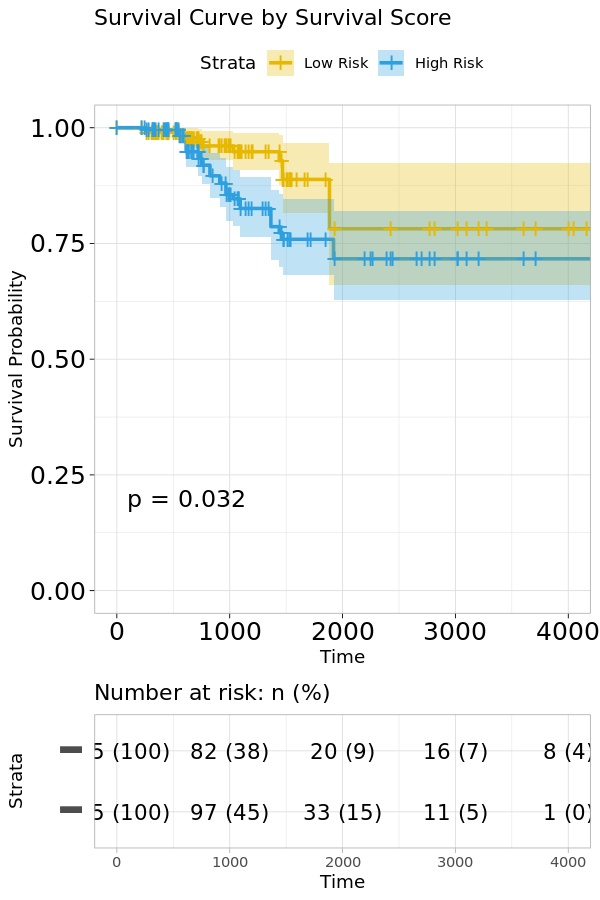

 [1] "SRSF2"  "GTF2I"  "CTNNA1" "STMN1"  "EPCAM"  "RAD21"  "LAMP1"  "PCNA"  
 [9] "PDIA6"  "GPI"    "ANP32B" "TOP2A"  "PRKDC"  "XPO1"   "EIF4A2" "CTNNB1"
[17] "YES1"   "MYH9"   "FUBP1"  "AFDN"  


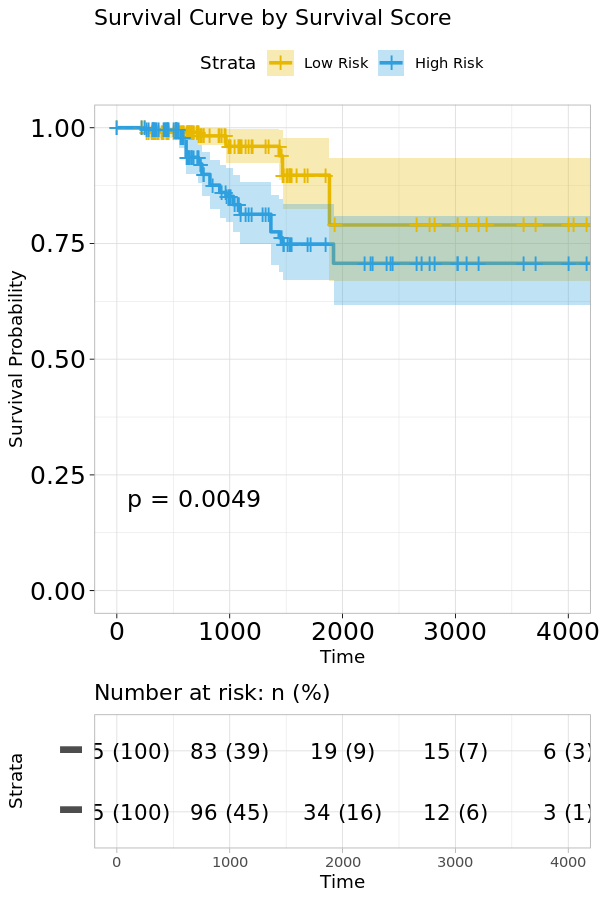

 [1] "SRSF2"   "GTF2I"   "CTNNA1"  "STMN1"   "EPCAM"   "RAD21"   "LAMP1"  
 [8] "PCNA"    "PDIA6"   "GPI"     "ANP32B"  "TOP2A"   "PRKDC"   "XPO1"   
[15] "EIF4A2"  "CTNNB1"  "YES1"    "MYH9"    "FUBP1"   "AFDN"    "CD47"   
[22] "PSMB7"   "DDX3X"   "CXCL9"   "CD164"   "GRB2"    "RPN2"    "DHX15"  
[29] "PSMD2"   "NASP"    "DHX9"    "SMARCA4" "STAT1"   "UBE2C"   "TRAF7"  
[36] "FH"      "CDK4"    "HDAC1"   "AKT2"    "ILF3"    "TYMS"    "EZH2"   
[43] "UBE2T"   "HMGA1"   "RBX1"    "EIF4E"   "PRKACB"  "SDHA"    "CCNB2"  
[50] "SF3B1"  


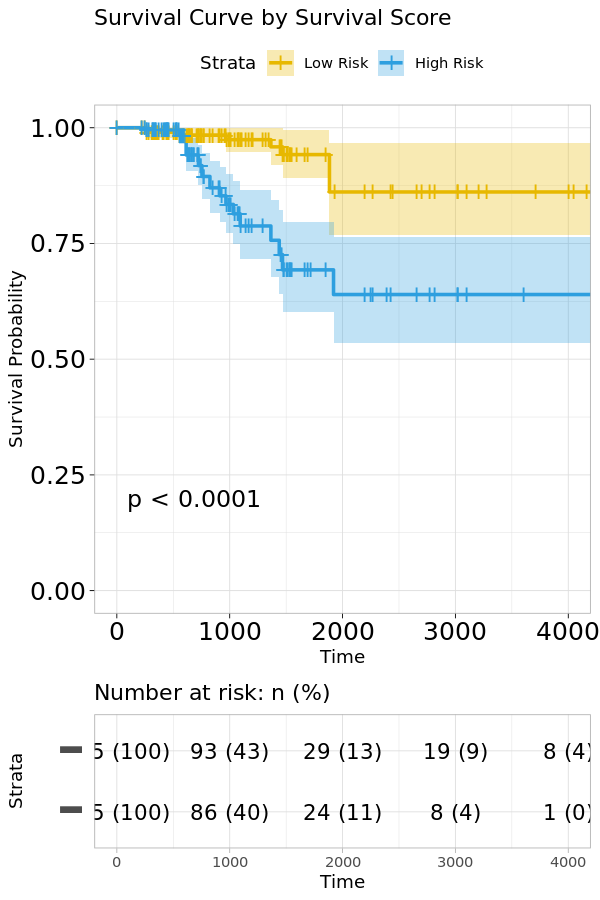

  [1] "SRSF2"    "GTF2I"    "CTNNA1"   "STMN1"    "EPCAM"    "RAD21"   
  [7] "LAMP1"    "PCNA"     "PDIA6"    "GPI"      "ANP32B"   "TOP2A"   
 [13] "PRKDC"    "XPO1"     "EIF4A2"   "CTNNB1"   "YES1"     "MYH9"    
 [19] "FUBP1"    "AFDN"     "CD47"     "PSMB7"    "DDX3X"    "CXCL9"   
 [25] "CD164"    "GRB2"     "RPN2"     "DHX15"    "PSMD2"    "NASP"    
 [31] "DHX9"     "SMARCA4"  "STAT1"    "UBE2C"    "TRAF7"    "FH"      
 [37] "CDK4"     "HDAC1"    "AKT2"     "ILF3"     "TYMS"     "EZH2"    
 [43] "UBE2T"    "HMGA1"    "RBX1"     "EIF4E"    "PRKACB"   "SDHA"    
 [49] "CCNB2"    "SF3B1"    "ID2"      "TAP1"     "LTBR"     "ARHGEF7" 
 [55] "BRD8"     "MSH6"     "CDKN1B"   "TPX2"     "HUWE1"    "MIF"     
 [61] "TGIF1"    "THRAP3"   "NFKBIA"   "CD63"     "ERBB3"    "TBL1XR1" 
 [67] "AKT1"     "IGF2R"    "WEE1"     "TANK"     "CAST"     "TP53"    
 [73] "USP1"     "ATF7IP"   "RFC4"     "MS4A1"    "ACTN1"    "KEAP1"   
 [79] "MAD2L2"   "MKI67"    "IDH2"     "ANXA2"    "CTNND1"   "PO

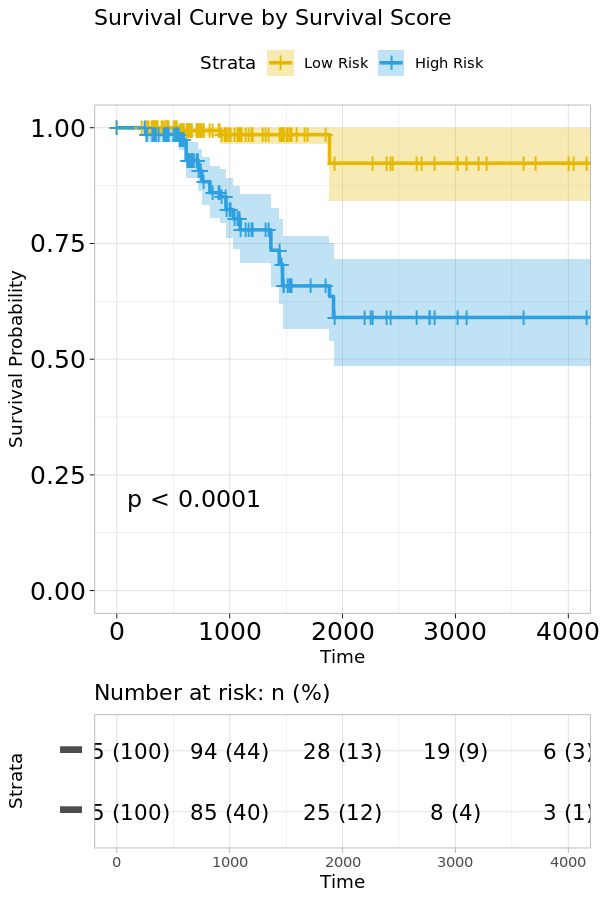

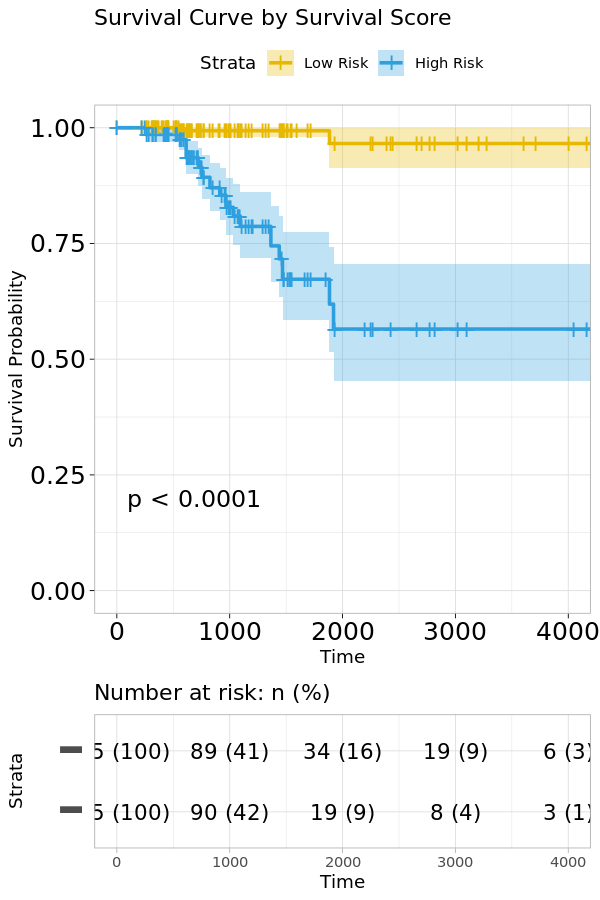

In [9]:
# top_pre_genes <- c('SRSF2','GTF2I','CTNNA1','STMN1','EPCAM')
unique_data_cpy <- unique_data
for(i in c(5,10,20,50,100)){
    top_pre_genes <- top_predict_genes$Gene[1:i]
    print(top_pre_genes)
####################################################################################################################                        
                        
    res_sig <- colnames(unique_data_cpy[colnames(unique_data_cpy) %in% top_pre_genes])
    unique_data <- unique_data_cpy[colnames(unique_data_cpy) %in% c("time","status",top_pre_genes)]
    formula_string <- paste("Surv(time, status) ~", paste(res_sig, collapse = " + "))
    res.cox <- coxph(as.formula(formula_string), data = unique_data)
    # options(repr.plot.width=5, repr.plot.height=5)
    # ggsurvplot(survfit(res.cox), color = "#2E9FDF",
    #            ggtheme = theme_minimal(),data=unique_data)

    # 1. Calculate survival scores
    survival_scores <- -predict(res.cox, type = "lp")
    # 2. Determine the median survival score
    median_score <- median(survival_scores)
    # 3. Categorize patients into high and low groups
    patient_groups <- ifelse(survival_scores > median_score, "High", "Low")
    # Add the patient groups to your original data (assuming your data is in 'lung' data frame)
    unique_data$SurvivalGroup <- patient_groups
    # Display the result
    table(unique_data$SurvivalGroup)

    ####################################################################################################################

    # Fit survival curves
    surv_curve <- survfit(Surv(time, status) ~ SurvivalGroup, data = unique_data)
    options(repr.plot.width=5, repr.plot.height=7.5)
    # pdf("/scratch/project/stseq/Onkar/STimage_v1/Outputs/Figures/TCGA_Survival_Pred.pdf",width=7.5,height=9)
    print(ggsurvplot(surv_curve, 
               pval = TRUE, 
               conf.int = TRUE, 
               risk.table.y.text.col = FALSE,
               risk.table.y.text = FALSE,
               risk.table = "abs_pct",
               ggtheme = theme_light(),
               legend.labs = c("Low Risk", "High Risk"),
               title = "Survival Curve by Survival Score",
               palette = c("#E7B800", "#2E9FDF"),
               ncensor.plot = FALSE, 
               font.tickslab = c(15, "plain", "black"),
               xlab = "Time", ylab = "Survival Probability"))
    # dev.off()
        }

#### Running for top-20 genes

In [ ]:
top_pre_genes <- top_predict_genes$Gene[1:20]

####################################################################################################################                        
                        
res_sig <- colnames(unique_data[colnames(unique_data) %in% top_pre_genes])
unique_data <- unique_data[colnames(unique_data) %in% c("time","status",top_pre_genes)]
colnames(unique_data)[colnames(unique_data) == "HLA-DRA"] <- "HLA_DRA"
formula_string <- paste("Surv(time, status) ~", paste(res_sig, collapse = " + "))
res.cox <- coxph(as.formula(formula_string), data = unique_data)
                        
options(repr.plot.width=5, repr.plot.height=5)
ggsurvplot(survfit(res.cox), color = "#2E9FDF",
           ggtheme = theme_minimal(),data=unique_data)
                        
# Assuming you have already fitted a multivariate Cox regression model 'res.cox'
# 1. Calculate survival scores
survival_scores <- -predict(res.cox, type = "lp")
# 2. Determine the median survival score
median_score <- median(survival_scores)
# 3. Categorize patients into high and low groups
patient_groups <- ifelse(survival_scores > median_score, "High", "Low")
# Add the patient groups to your original data (assuming your data is in 'lung' data frame)
unique_data$SurvivalGroup <- patient_groups
# Display the result
table(unique_data$SurvivalGroup)
                        
####################################################################################################################
                        
# Fit survival curves
surv_curve <- survfit(Surv(time, status) ~ SurvivalGroup, data = unique_data)
# Create a ggsurvplot
options(repr.plot.width=5, repr.plot.height=7.5)
pdf("/scratch/project/stseq/Onkar/STimage_v1/Outputs/Figures/TCGA_Survival_Pred.pdf",width=6,height=6)
ggsurvplot(surv_curve, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table.y.text.col = FALSE,
           risk.table.y.text = FALSE,
           risk.table = FALSE,
           ggtheme = theme_light(),
           legend.labs = c("Low Risk", "High Risk"),
           title = "Survival Curve by Survival Score",
           palette = c("#E7B800", "#2E9FDF"),
           ncensor.plot = FALSE, 
           font.tickslab = c(15, "plain", "black"),
           xlab = "Time", ylab = "Survival Probability")
dev.off()

### True bluk gene expression

In [8]:
all_bulk_ge = read.csv("/scratch/project/stseq/Onkar/STimage_v1/Survival/Updated2_bluk_ge.csv")
all_bulk_ge <- all_bulk_ge %>%
               group_by(gene_name) %>%
               summarize(across(where(is.numeric), mean))
all_bulk_ge <- t(all_bulk_ge)
all_bulk_ge <- as.data.frame(all_bulk_ge)
all_bulk_ge <- janitor::row_to_names(all_bulk_ge,1)
rownames(all_bulk_ge) <- gsub("\\.", "-", rownames(all_bulk_ge))
patients_rownames <- rownames(all_bulk_ge)
all_bulk_ge <- apply(all_bulk_ge, 2, function(x) as.numeric(as.character(x)))
rownames(all_bulk_ge) <- patients_rownames
all_bulk_ge <- as.data.frame(all_bulk_ge)
all_bulk_ge$pateint <- sub("\\-1$", "", rownames(all_bulk_ge))
all_bulk_ge$pateint <- substring(rownames(all_bulk_ge), 1, nchar(rownames(all_bulk_ge)) - 4)
all_bulk_ge <- all_bulk_ge %>%
               group_by(pateint) %>%
               summarize(across(where(is.numeric), mean))
all_bulk_ge <- as.data.frame(all_bulk_ge)
all_bulk_ge <- all_bulk_ge %>% column_to_rownames(var = "pateint")
                     
##############################                     
# rownames(all_bulk_ge) <- substring(rownames(all_bulk_ge), 1, 
#                                               nchar(rownames(all_bulk_ge)) - 4)
##############################
                     
survival_info <- unique(survival_info[c("case_id","case_submitter_id","time","vital_status","ajcc_pathologic_stage")])
data = merge(survival_info[c("case_submitter_id","time","vital_status")], 
                   all_bulk_ge, by.x = "case_submitter_id", by.y = "row.names")

unique_bulk_data <- data[!duplicated(data), ]
unique_bulk_data <- unique_bulk_data %>% remove_rownames %>% column_to_rownames(var="case_submitter_id")
colnames(unique_bulk_data)[2] <- "status" 
unique_bulk_data$status <- ifelse(unique_bulk_data$status == "Dead", 1, 0)
colnames(unique_bulk_data) <- gsub("[[:space:]-]+", "_", colnames(unique_bulk_data))

#### Running for multiple top genes

In [ ]:
unique_bulk_data_cpy <- unique_bulk_data
for(i in c(5,10,20,50,100)){
    top_pre_genes <- top_predict_genes$Gene[1:i]
    print(top_pre_genes)

####################################################################################################################                        
                        
    res_sig <- colnames(unique_bulk_data_cpy[colnames(unique_bulk_data_cpy) %in% top_pre_genes])
    unique_bulk_data <- unique_bulk_data_cpy[colnames(unique_bulk_data_cpy) %in% c("time","status",top_pre_genes)]
    # colnames(unique_bulk_data)[colnames(unique_bulk_data) == "HLA-DRA"] <- "HLA_DRA"
    formula_string <- paste("Surv(time, status) ~", paste(res_sig, collapse = " + "))
    res.cox <- coxph(as.formula(formula_string), data = unique_bulk_data)

#     options(repr.plot.width=5, repr.plot.height=5)
#     ggsurvplot(survfit(res.cox), color = "#2E9FDF",
#                ggtheme = theme_minimal(),data=unique_bulk_data)

    # Assuming you have already fitted a multivariate Cox regression model 'res.cox'
    # 1. Calculate survival scores
    survival_scores <- -predict(res.cox, type = "lp")
    # 2. Determine the median survival score
    median_score <- median(survival_scores)
    # 3. Categorize patients into high and low groups
    patient_groups <- ifelse(survival_scores > median_score, "High", "Low")
    # Add the patient groups to your original data (assuming your data is in 'lung' data frame)
    unique_bulk_data$SurvivalGroup <- patient_groups
    # Display the result
    table(unique_bulk_data$SurvivalGroup)

    ####################################################################################################################

    # Fit survival curves
    surv_curve <- survfit(Surv(time, status) ~ SurvivalGroup, data = unique_bulk_data)
    # Create a ggsurvplot
    options(repr.plot.width=5, repr.plot.height=7.5)
    # pdf("/scratch/project/stseq/Onkar/STimage_v1/Outputs/Figures/TCGA_Survival_True.pdf",width=7.5,height=9)
    print(ggsurvplot(surv_curve, 
               pval = TRUE, 
               conf.int = TRUE, 
               risk.table.y.text.col = FALSE,
               risk.table.y.text = FALSE,
               risk.table = "abs_pct",
               ggtheme = theme_light(),
               legend.labs = c("Low Risk", "High Risk"),
               title = "Survival Curve by Survival Score",
               palette = c("#E7B800", "#2E9FDF"),
               ncensor.plot = FALSE, 
               font.tickslab = c(15, "plain", "black"),
               xlab = "Time", ylab = "Survival Probability"))
# dev.off()
    }

#### Running for top-20 genes

In [ ]:
unique_bulk_data_cpy <- unique_bulk_data
top_pre_genes <- top_predict_genes$Gene[1:20]

####################################################################################################################                        
                        
res_sig <- colnames(unique_bulk_data_cpy[colnames(unique_bulk_data_cpy) %in% top_pre_genes])
unique_bulk_data <- unique_bulk_data_cpy[colnames(unique_bulk_data_cpy) %in% c("time","status",top_pre_genes)]
formula_string <- paste("Surv(time, status) ~", paste(res_sig, collapse = " + "))
res.cox <- coxph(as.formula(formula_string), data = unique_bulk_data)

# 1. Calculate survival scores
survival_scores <- -predict(res.cox, type = "lp")
# 2. Determine the median survival score
median_score <- median(survival_scores)
# 3. Categorize patients into high and low groups
patient_groups <- ifelse(survival_scores > median_score, "High", "Low")
# Add the patient groups to your original data (assuming your data is in 'lung' data frame)
unique_bulk_data$SurvivalGroup <- patient_groups
# Display the result
table(unique_bulk_data$SurvivalGroup)

####################################################################################################################

# Fit survival curves
surv_curve <- survfit(Surv(time, status) ~ SurvivalGroup, data = unique_bulk_data)
# Create a ggsurvplot
options(repr.plot.width=5, repr.plot.height=7.5)
pdf("/scratch/project/stseq/Onkar/STimage_v1/Outputs/Figures/TCGA_Survival_True.pdf",width=6,height=6)
print(ggsurvplot(surv_curve, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table.y.text.col = FALSE,
           risk.table.y.text = FALSE,
           risk.table = FALSE,
           ggtheme = theme_light(),
           legend.labs = c("Low Risk", "High Risk"),
           title = "Survival Curve by Survival Score",
           palette = c("#E7B800", "#2E9FDF"),
           ncensor.plot = FALSE, 
           font.tickslab = c(15, "plain", "black"),
           xlab = "Time", ylab = "Survival Probability"))
dev.off()